# DAND - Data Analysis Nanodegree - Project 2 - Wrangle OpenStreetMap Data - Report
## Prologue
Hello World! This is the second project from Udacity Data Analysis Nanodegree program. This project deals with the problem of parsing data from the site [OpenStreetMap](www.openstreetmap.org), OpenStreetMap powers map data on thousands of web sites, mobile apps, and hardware devices. OpenStreetMap is built by a community of mappers that contribute and maintain data about roads, trails, cafés, railway stations, and much more, all over the world. Is community driven, and relies in Open Data. Every user can store an area of his/her interest at the computer in xml form. OpenStreetMap is an open-source project which provides free maps of the entire world from volunteers who entere the data. It is maintained by the OpenStreetMap foundation and is a colloborative effort with over 2 million contributors. OpenStreetMap data is freely available to download in many formats and presents an ideal opportunity to practice the art of data wrangling for several reasons. The entire dataset is user-generated meaning there will be a significant quantity of “dirty” data. The dataset is for any area is free to download in many formats including XML (eXtensible Markup Language). The data are relatable and human-understandable because they represent real places and features

# Contents:
The organization of the case is as follows

1. <a href="#Introduction">Introduction </a>
2. <a href="#DataOverview">Data overview </a>
3. <a href="#Audit">Description of auditing process </a>
4. <a href="#Clean">Description of cleaning plan</a>
5. <a href="#XMLToCSV">From OSM - XML and CSV to SQL Database</a>
6. <a href="#Query">Quering the SQLite Database</a>
7. <a href="#Ideas">Additional ideas</a>
8. <a href="#Conclusion">Conclusion of this case study</a>
9. <a href="#Sources">Sources</a>

# <div id="Introduction"> 1) Introduction</div>
This particular project, explores the City of London in the United Kingdom using the information
available in the Open Street Map. The purpose of this analysis is to use Data Wrangling techniques
to load, audit, clean and analyze a big dataset using Python and SQLite. The city of London OSM
dataset is used as a case study.

## Downloading / Fetching the data from OpenStreetMap
London is one of the cities that I want to visit one day in the future, until this day comes, I will explore the city from OpenStreetMap site. In order to fetch the city of London we have to export tha map from the site via the Overpass API. The Overpass API utility can download large portion of maps from OpenStreetMap site without any difficulty. The site where a user can fetch the data is the [following](https://www.openstreetmap.org/export#map=10/51.5083/-0.1277).

An overview for the city of London can be illustrated from the OpenStreetMap site:

<img src="/Images/London_OSM.png" width="1200">

After fetching the OSM file which is an xml the document has the following format:

<img src="/Images/OSM_Format.png" width="1200">

The OSM file consists of some fundamental elements:

- **Node**, a node is one of the core elements in the OpenStreetMap data model. It consists of a single point in space defined by its latitude, longitude and node id.
- **Way**, A way is an ordered list of nodes which normally also has at least one tag or is included within a Relation. A way can have between 2 and 2,000 nodes, although it's possible that faulty ways with zero or a single node exist. A way can be open or closed. A closed way is one whose last node on the way is also the first on that way. A closed way may be interpreted either as a closed polyline, or an area, or both.
- **Tag**, A tag consists of two items, a key and a value. Tags describe specific features of map elements (nodes, ways, or relations) or changesets. Both items are free format text fields, but often represent numeric or other structured items. Conventions are agreed on the meaning and use of tags, which are captured on this wiki.
- **Relation**, A relation is one of the core data elements that consists of one or more tags and also an ordered list of one or more nodes, ways and/or relations as members which is used to define logical or geographic relationships between other elements.

# <div id="DataOverview"> 2) Data Overview</div> 
Before proceeding to the auditing phase I wanted to find out the total number of tags that exist inside the London OSM file that I downloaded. The following code parse the OSM XML file and different number of tags which from their part are stored inside a dictionary

In [1]:
import xml.etree.cElementTree as ET
import pprint
from collections import defaultdict


def count_tags(filename):
    """ The top tags and how many of each"""
    counts = defaultdict(int)
    for event, node in ET.iterparse(filename):
        if event == 'end': 
            counts[node.tag]+=1
        node.clear()             
    return counts

filename = 'maps-xml/london_full.osm'
pprint.pprint(count_tags(filename))

defaultdict(<class 'int'>,
            {'bounds': 1,
             'member': 515957,
             'meta': 1,
             'nd': 9444740,
             'node': 7254473,
             'note': 1,
             'osm': 1,
             'relation': 26194,
             'remark': 1,
             'tag': 5010923,
             'way': 1181849})


As we can see, the London OSM file is a huge file and contains lots of information for example it is impressive that contains 5 millions tags and 1 millions way tags and last but not least 7.2 million nodes.

## Counting the different types of k attribute
Node and Way Tags are fundamental tags for the OSM/XML file structure. inside these main tag there is the **'k'** attribute which represents an attribute and next to him has the **'v'** attribute which contains the value for the k attribute. The following function finds the different attributes that are represented by the **'k'** value and measure the number of their appreance.

In [2]:
import pprint
import xml.etree.cElementTree as ET

def get_types_of_k_attrib(filename, k_attrib_values_dict):
    
    for _, element in ET.iterparse(filename):
        if element.tag == "node" or element.tag == "way":
            for tag in element.iter("tag"):
                #print(tag.attrib['k'])
                if tag.attrib['k'] not in k_attrib_values_dict:
                    k_attrib_values_dict[tag.attrib['k']] = 1
                else:
                    k_attrib_values_dict[tag.attrib['k']] += 1
                tag.clear()
            element.clear()

if __name__ == '__main__':
    
    k_attrib_values_dict = {}
    
    filename = "maps-xml/london_full.osm"
    get_types_of_k_attrib(filename, k_attrib_values_dict)
    
    #print the top 20 k values appeared in the center of London
    import operator
    pprint.pprint(sorted(k_attrib_values_dict.items(),key = operator.itemgetter(1),reverse = True)[1:21])

[('highway', 492725),
 ('name', 369615),
 ('source', 337545),
 ('addr:street', 223336),
 ('addr:housenumber', 212889),
 ('created_by', 124064),
 ('natural', 118562),
 ('maxspeed', 110843),
 ('amenity', 97686),
 ('lit', 96278),
 ('operator', 81566),
 ('surface', 74486),
 ('barrier', 72657),
 ('note', 64708),
 ('addr:city', 63191),
 ('building:levels', 60381),
 ('addr:postcode', 54849),
 ('oneway', 54790),
 ('ref', 54370),
 ('species', 53815)]


It seems that the top 5 k attributes represent: highways, names, sources and addresses.

# <div id="Audit">3) Description of auditing process</div>
Auditing the OSM file for London is a challenge due to the OSM's filesize, it reaches almost 1.7GB in size. The OSM file is large and contains a wide array of information from nodes and ways. The efforts of the auditing process were focused in auditing the following information with the purpose of showing how to handle different problems:

- Data types
- Node coordinates (latitude and longitude)
- Postal code format
- Street names

## Data Quality
I conducted this auditing process using the measurements of data quality as needed, There are five main aspects of data quality to consider when auditing a dataset:

- Validity: Does the data conform to a standard format?
- Accuracy: Does the data agree with reality or with a trusted external source?
- Completeness: Are all records present?
- Consistency: Is data in a field (down a column) or for an instance (across a row) in logical agreement?
- Uniformity: Are the same units used across a given field?

## Auditing Data types
Lets start some auditing by checking out the data types for the fundamental tags inside the OSM - XML file which are:

- Node
- Node Tag
- Way
- Way Tags
- Way Nd tags 

The data types were checked for each element attribute in nodes and ways using the following code.

In [3]:
from collections import defaultdict

# Dictionaries to store data types
node_field_types = defaultdict(set)
node_tag_field_types = defaultdict(set)
way_field_types = defaultdict(set)
way_tag_field_types = defaultdict(set)
way_node_field_types = defaultdict(set)

# A function to audits the type of the attributes of an element
def audit_attribute_type(types_dictionary, attributes):
    for attribute in attributes:
        value = attributes[attribute]
        if value == "NULL" or value == "" or value == None or value == type(None):
            types_dictionary[attribute].add(type(None))
        elif value.startswith("{") and value.endswith("}"):
            types_dictionary[attribute].add(type([]))
        elif is_number(value):
            try:
                int(value)
                types_dictionary[attribute].add(type(1))
            except ValueError:
                float(value)
                types_dictionary[attribute].add(type(1.1))
        else:
            types_dictionary[attribute].add(type("a"))

In the following figure it can be seen that with the exception of user and value (v) attributes, all the
fields have one data type. In the case of user this is not a problem as the value represents a key and
all entries can be treated as strings.
In the case of the node-tag and way-tag value attribute, types need to be treated on a case by case
basis, as they represent different information. For example, some values represent postal codes,
labels, hours, names, maximum speed allowed, apartment numbers, etc.

![XML-types_1](/Images/xml-types-1.png)
![XML-types_2](/Images/xml-types-2.png)

The result show for every fundamental tag, from nodes to ways and their corresponded tags, their values (v) are described with a wide range of different data types. This is very informative later when we build the SQL schema for our database and define which datatypes to choose for the values that will be stored inside.

### Auditing coordinates

To verify that the coordinates were correct, first it was checked that the data type was float value
considering the information previously presented. As the latitude and longitude both have a float
type, there are no coordinates in another format.
Furthermore, I verified that the coordinates were in a reasonable range. For this a square area
around London was defined. A function was built to verify that the coordinates in the OSM fall inside
the area, otherwise they were stored in a dictionary for further analysis.
The code that was used is the following.

In [4]:
# A function which audits the node's coordinates and stores those who do not belong to the area from the map
def audit_coordinates(coordinates_out_area, element_attributes):
    node_id = element_attributes['id']
    lati = float(element_attributes['lat'])
    longi = float(element_attributes['lon'])
    # Evaluates if the latitude and longitude fall outside the area of interest
    if not (51.7573 < lati < 51.2550) or not (-0.8253 < longi < 0.5699):
        coordinates_out_area[node_id] = (lati, longi)

For this dataset 7254473 entries in the nodes were not valid. This means that sometimes the information provided by the community and the users was not accurate enough and invalid coordinates were given.

### Auditing postal codes
According to the Post codes in the United Kingdom
(https://en.wikipedia.org/wiki/Postcodes_in_the_United_Kingdom#Listings_and_availability) article
the syntax of the postal code in London can be described as follows:
Alphanumeric
Variable in length ranging from six to eight characters (including a space) long
Each post code is divided into two parts separated by a single space:
Outward code: includes the postcode area (one or two-letter) and the postcode
district (one or two digits)
Inward code: includes the postcode sector (one number) and the postcode unit
(two letters).
Additionally, the post code area for London corresponds to a division of the city in EC (East
Central), WC (West Central), N (North), E (East), SE (South East), SW (South West), W
(West), and NW (North West).

Fortunately the UK government provides the following regular expression to validate UK postal codes:

> *([Gg][Ii][Rr] 0[Aa]{2})|((([A-Za-z][0-9]{1,2})|(([A-Za-z][A-Ha-hJ-Yj-y][0-9]{1,2})|(([A-Za-z][0-9][A-Za-z])|([A-Za-z][A-Ha-hJ-Yj-y][0-9]?[A-Za-z])))) [0-9][A-Za-z]{2})$*

The place where the regular expression lies is in the Wikipedia page about UK postal codes [source](https://en.wikipedia.org/wiki/Postcodes_in_the_United_Kingdom#Validation).

The following python snippet audits the postal codes:

In [5]:
from collections import defaultdict
import re

# Data structure to store postal code types
postal_code_types = defaultdict(set)

# another list of regular expressions for auditing and cleaning postal codes
# kudos to https://en.wikipedia.org/wiki/Postcodes_in_the_United_Kingdom#validation
postal_code_no_space_re = re.compile(r'^([Gg][Ii][Rr] 0[Aa]{2})|((([A-Za-z][0-9]{1,2})|(([A-Za-z][A-Ha-hJ-Yj-y][0-9]{1,2})|(([A-Za-z][0-9][A-Za-z])|([A-Za-z][A-Ha-hJ-Yj-y][0-9]?[A-Za-z])))) [0-9][A-Za-z]{2})$')
postal_code_with_space_re = re.compile(r'^([Gg][Ii][Rr] 0[Aa]{2})|((([A-Za-z][0-9]{1,2})|(([A-Za-z][A-Ha-hJ-Yj-y][0-9]{1,2})|(([A-Za-z][0-9][A-Za-z])|([A-Za-z][A-Ha-hJ-Yj-y][0-9]?[A-Za-z])))) {0,1}[0-9][A-Za-z]{2})$')


# A function which audits postal codes and catagorizes based on the way are written
def audit_postal_code(child_attributes):
    if child_attributes['k'] == 'postal_code':
        postal_code = child_attributes['v']
        if postal_code_no_space_re.match(postal_code):
            postal_code_types['ps_no_space'].add(postal_code)
            counter_postal_code_types['ps_no_space'] += 1
        elif postal_code_with_space_re.match(postal_code):
            postal_code_types['ps_with_space'].add(postal_code)
            counter_postal_code_types['ps_with_space'] += 1
        else:
            postal_code_types['unknown'].add(postal_code)
            counter_postal_code_types['unknown'] += 1

The result is the following:

![postal codes types](Images/postal_code_types.png)


This means that 1783 postal codes from nodes and ways have been written without space and 6729 does not follow the format based on the regular expression provided by the UK government. Especially for the 6729 postal codes, the may have written in another format similar to the one provided by the UK goverment or maybe some users have provided postal codes in wrong format.

### Auditing Street Names
Node and Way tags contain street names are written in many forms. These forms may be in Capitalized form, in lowercase form, in UPPERCASE form. Sometimes they may have symbols such as lower colon inside the street name. Last but not least it may contain numbers with the street name and even parts of the postal code. In order to organize and audit all the different type of street types, a function was created and identify street name patterns based on the followings:

- capitalized street names patterns
- uppercase street names patterns
- lower street names patterns
- capitalized with colon street names patterns
- uppercase with colon street names patterns
- lowercase with colon street names patterns
- problematic street names patterns

In [6]:
import re

# regular expressions for auditing the different ways that a address is stored in OSM xml file
capitalized_re = re.compile(r'^[A-Z][a-z]*\s+([A-Z]?[a-z]*|\s+)*$')
uppercase_re = re.compile(r'^([A-Z|_|\s+])+$')
lower_re = re.compile(r'^([a-z]|_|\s+)+$')
capitalized_colon_re = re.compile(r'^[A-Z][a-z]+\s+([A-Z][a-z]*|\s+|:)*$')
uppercase_colon_re = re.compile(r'^([A-Z|_|\s+|:])+$')
lower_colon_re = re.compile(r'^([a-z]|_)*:([a-z]|_)*$')
problem_chars_re = re.compile(r'[=\+/&<>;\'"\?%#$@\,\. \t\r\n]')

# Counter for address name types
counter_address_types = {"uppercase": 0, "capitalized": 0, "lower": 0, "uppercase_colon": 0, "capitalized_colon": 0,
                "lower_colon": 0, "problem_chars": 0, "other": 0}

# A function which categorizes an address based on the way is written
def audit_address_name(element):

        if lower_re.search(element):
            counter_address_types['lower'] = counter_address_types['lower'] + 1
        elif uppercase_re.search(element):
            counter_address_types['uppercase'] = counter_address_types['uppercase'] + 1
        elif capitalized_re.search(element):
            counter_address_types['capitalized'] = counter_address_types['capitalized'] + 1
        elif lower_colon_re.search(element):
            counter_address_types['lower_colon'] = counter_address_types['lower_colon'] + 1
        elif uppercase_colon_re.search(element):
            counter_address_types['uppercase_colon'] = counter_address_types['uppercase_colon'] + 1
        elif capitalized_colon_re.search(element):
            counter_address_types['capitalized_colon'] = counter_address_types['capitalized_colon'] + 1
        elif problem_chars_re.search(element):
            counter_address_types['problem_chars'] = counter_address_types['problem_chars'] + 1
        else:
            counter_address_types['other'] = counter_address_types['other'] + 1

![Street Names counter](Images/street_names_counter.png)

Capitalized address names are the majority of the all the addresses. 5412 addresses contain problematic characters such as symbols like dollar sign or punctuations. It is important to be mentioned that 5215 addresses were categorized as other type of addresses, which means that they did not match any of the regular expressions as mentioned above and neither are problematic characters. This may mean that these addresses are written in another language than english.

### Auditing Street Names

Another problem with Street names is the abbreviations at the end of a street name which is call street type. For example St. st. Str. means the same thing which is Street. In order to cope with that issue I manually explored all the Street types which are the last part from the Street names and I found out all the abbreviations and mapped them into a single word.

The following code contains all the general idea about auditing street names as described above:

In [7]:
import re

# a list of regular expressions for auditing and cleaning street types
street_type_re = re.compile(r'\b\S+\.?$', re.IGNORECASE)
cleaning_re_omit_streets_ending_with_numbers_re = re.compile(r'\s*\d+\S*$', re.IGNORECASE)
cleaning_re_at_least_three_words_re = re.compile(r'[A-Z][a-z]{2,}$')

# a set with all the candidate street types
candidate_street_type_set = set()

# expected street endings
expected_list = ["Street", "Road", "Avenue", "Boulevard"]

# UPDATE THIS VARIABLE, this variable contains address' endings writen in different forms and have the same meaning
# in order to contain this issue a mapping variable was created in order to map the different endings who have the
# same meaning
mapping = {"St": "Street", "street": "Street", "road": "Road", "St.": "Street", "st": "Street",
           "Ave": "Avenue", "HIll": "Hill", "boulevard": "Boulevard", "close": "Close",
           "drive": "Drive", "footway": "Footway", "house": "House", "lane": "Lane",
           "market": "Market", "parade": "Parade", "park": "Park", "passage": "Passage",
           "place": "Place", "residential": "Residential", "Sq": "Square", "Road)": "Road",
           "Rd)": "Road", "Rd": "Road", "Rd,": "Road", "ROAD": "Road", "ROAD,": "Road", "Pl": "Place",
           "North)": "North", "James'": "James", "James's": "James", "GROVE": "Grove", "station": "Station",
           "square": "Square", "shops": "Shops", "row": "Row", "STREET": "Street", "Park,": "Park",
           "Lower)": "Lower"}

def audit_street_type(street_name):

    # debug print
    # print(street_name)

    # get the final word which will be the street type from the address
    candidate_street_type = street_type_re.search(street_name)

    if candidate_street_type:
        street_type = candidate_street_type.group()
        street_type = street_type.strip()

        # add the candidate street type into a set
        candidate_street_type_set.add(street_type)

        # cleaning process:
        # omit street types that end with numbers or numbers with letters
        check_for_strange_ending_address = cleaning_re_omit_streets_ending_with_numbers_re.search(street_type)
        if not check_for_strange_ending_address:

            # if the newly found street type is in the expected_list, then append to the dict with key
            # the street type and value the street name
            if street_type in expected_list:
                # debug print
                # print("expected street:", street_type, ",", street_name)
                street_types[street_type].add(street_name)

            # else if the newly found street type is not in expected list then search it in mapping list
            elif street_type not in expected_list and street_type in mapping:

                street_name = update_name(street_name)
                # debug print
                # print("mapping new key:", street_type, ",", street_name)
                street_types[mapping[street_type]].add(street_name)

            # else check if is a valid written in english street type then add it to expected list
            elif street_type not in expected_list and street_type not in mapping:

                if cleaning_re_at_least_three_words_re.search(street_type) and is_english_word(street_type):
                    # debug print
                    # print("Adding new key:", street_type, ",", street_name)
                    street_types[street_type].add(street_name)
                    expected_list.append(street_type)

The previous audit python function supports both auditing and cleaning street names and it is achieved via the mapping of the abbreviations.

## Complete Auditing Process
The following python code describes the whole audit process as described from the previous steps, by executing the following python snippet all the audit process will be implemented and printed as described above:

In [9]:
"""
Auditing the OSM - XML file for the City of London
"""
import xml.etree.cElementTree as ET
from collections import defaultdict
import re
import pprint
import time

# Pinpointing the OSM input file
OSMFILE = "maps-xml/london_full.osm"

# Dictionaries to store data types
node_field_types = defaultdict(set)
node_tag_field_types = defaultdict(set)
way_field_types = defaultdict(set)
way_tag_field_types = defaultdict(set)
way_node_field_types = defaultdict(set)

# Data structure used to store wrong coordinates
coordinates_out_of_area = {}

# Data structure to store street types
street_types = defaultdict(set)

# Data structure to store postal code types
postal_code_types = defaultdict(set)

# Counter for postal code types
counter_postal_code_types = {'postal_code_no_space': 0, 'postal_code_with_space': 0, 'unknown': 0}

# Counter for address name types
counter_address_types = {"uppercase": 0, "capitalized": 0, "lower": 0, "uppercase_colon": 0, "capitalized_colon": 0,
                "lower_colon": 0, "problem_chars": 0, "other": 0}

# a list of regular expressions for auditing and cleaning street types
street_type_re = re.compile(r'\b\S+\.?$', re.IGNORECASE)
cleaning_re_omit_streets_ending_with_numbers_re = re.compile(r'\s*\d+\S*$', re.IGNORECASE)
cleaning_re_at_least_three_words_re = re.compile(r'[A-Z][a-z]{2,}$')

# regular expressions for auditing the different ways that a address is stored in OSM xml file
capitalized_re = re.compile(r'^[A-Z][a-z]*\s+([A-Z]?[a-z]*|\s+)*$')
uppercase_re = re.compile(r'^([A-Z|_|\s+])+$')
lower_re = re.compile(r'^([a-z]|_|\s+)+$')
capitalized_colon_re = re.compile(r'^[A-Z][a-z]+\s+([A-Z][a-z]*|\s+|:)*$')
uppercase_colon_re = re.compile(r'^([A-Z|_|\s+|:])+$')
lower_colon_re = re.compile(r'^([a-z]|_)*:([a-z]|_)*$')
problem_chars_re = re.compile(r'[=\+/&<>;\'"\?%#$@\,\. \t\r\n]')

# another list of regular expressions for auditing and cleaning postal codes
# kudos to https://en.wikipedia.org/wiki/Postcodes_in_the_United_Kingdom#validation
postal_code_no_space_re = re.compile(r'^([Gg][Ii][Rr] 0[Aa]{2})|((([A-Za-z][0-9]{1,2})|(([A-Za-z][A-Ha-hJ-Yj-y][0-9]{1,2})|(([A-Za-z][0-9][A-Za-z])|([A-Za-z][A-Ha-hJ-Yj-y][0-9]?[A-Za-z])))) [0-9][A-Za-z]{2})$')
postal_code_with_space_re = re.compile(r'^([Gg][Ii][Rr] 0[Aa]{2})|((([A-Za-z][0-9]{1,2})|(([A-Za-z][A-Ha-hJ-Yj-y][0-9]{1,2})|(([A-Za-z][0-9][A-Za-z])|([A-Za-z][A-Ha-hJ-Yj-y][0-9]?[A-Za-z])))) {0,1}[0-9][A-Za-z]{2})$')


# a set with all the candidate street types
candidate_street_type_set = set()

# expected street endings
expected_list = ["Street", "Road", "Avenue", "Boulevard"]

# UPDATE THIS VARIABLE, this variable contains address' endings writen in different forms and have the same meaning
# in order to contain this issue a mapping variable was created in order to map the different endings who have the
# same meaning
mapping = {"St": "Street", "street": "Street", "road": "Road", "St.": "Street", "st": "Street",
           "Ave": "Avenue", "HIll": "Hill", "boulevard": "Boulevard", "close": "Close",
           "drive": "Drive", "footway": "Footway", "house": "House", "lane": "Lane",
           "market": "Market", "parade": "Parade", "park": "Park", "passage": "Passage",
           "place": "Place", "residential": "Residential", "Sq": "Square", "Road)": "Road",
           "Rd)": "Road", "Rd": "Road", "Rd,": "Road", "ROAD": "Road", "ROAD,": "Road", "Pl": "Place",
           "North)": "North", "James'": "James", "James's": "James", "GROVE": "Grove", "station": "Station",
           "square": "Square", "shops": "Shops", "row": "Row", "STREET": "Street", "Park,": "Park",
           "Lower)": "Lower"}


# the function audit the street names, extracts the street type and corrects possible street type abbreviations
def audit_street_type(street_name):

    # debug print
    # print(street_name)

    # get the final word which will be the street type from the address
    candidate_street_type = street_type_re.search(street_name)

    if candidate_street_type:
        street_type = candidate_street_type.group()
        street_type = street_type.strip()

        # add the candidate street type into a set
        candidate_street_type_set.add(street_type)

        # cleaning process:
        # omit street types that end with numbers or numbers with letters
        check_for_strange_ending_address = cleaning_re_omit_streets_ending_with_numbers_re.search(street_type)
        if not check_for_strange_ending_address:

            # if the newly found street type is in the expected_list, then append to the dict with key
            # the street type and value the street name
            if street_type in expected_list:
                # debug print
                # print("expected street:", street_type, ",", street_name)
                street_types[street_type].add(street_name)

            # else if the newly found street type is not in expected list then search it in mapping list
            elif street_type not in expected_list and street_type in mapping:

                street_name = update_name(street_name)
                # debug print
                # print("mapping new key:", street_type, ",", street_name)
                street_types[mapping[street_type]].add(street_name)

            # else check if is a valid written in english street type then add it to expected list
            elif street_type not in expected_list and street_type not in mapping:

                if cleaning_re_at_least_three_words_re.search(street_type) and is_english_word(street_type):
                    # debug print
                    # print("Adding new key:", street_type, ",", street_name)
                    street_types[street_type].add(street_name)
                    expected_list.append(street_type)


# A function which checks whether or not a string is written in english or not
def is_english_word(s):
    try:
        s.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:
        return True


# A function which checks whether the 'k' attribute for an xml element is addr:street type
def is_street_name(elem):
    return elem.attrib['k'] == "addr:street"


# A function to detect whether the values is an integer or a float
def is_number(v):
    try:
        int(v)
        return True
    except ValueError:
        try:
            float(v)
            return True
        except ValueError:
            return False


# A function which categorizes an address based on the way is written
def audit_address_name(element):

        if lower_re.search(element):
            counter_address_types['lower'] = counter_address_types['lower'] + 1
        elif uppercase_re.search(element):
            counter_address_types['uppercase'] = counter_address_types['uppercase'] + 1
        elif capitalized_re.search(element):
            counter_address_types['capitalized'] = counter_address_types['capitalized'] + 1
        elif lower_colon_re.search(element):
            counter_address_types['lower_colon'] = counter_address_types['lower_colon'] + 1
        elif uppercase_colon_re.search(element):
            counter_address_types['uppercase_colon'] = counter_address_types['uppercase_colon'] + 1
        elif capitalized_colon_re.search(element):
            counter_address_types['capitalized_colon'] = counter_address_types['capitalized_colon'] + 1
        elif problem_chars_re.search(element):
            counter_address_types['problem_chars'] = counter_address_types['problem_chars'] + 1
        else:
            counter_address_types['other'] = counter_address_types['other'] + 1


# A function to audits the type of the attributes of an element
def audit_attribute_type(types_dictionary, attributes):
    for attribute in attributes:
        value = attributes[attribute]
        if value == "NULL" or value == "" or value == None or value == type(None):
            types_dictionary[attribute].add(type(None))
        elif value.startswith("{") and value.endswith("}"):
            types_dictionary[attribute].add(type([]))
        elif is_number(value):
            try:
                int(value)
                types_dictionary[attribute].add(type(1))
            except ValueError:
                float(value)
                types_dictionary[attribute].add(type(1.1))
        else:
            types_dictionary[attribute].add(type("a"))


# A function which audits the node's coordinates and stores those who do not belong to the area from the map
def audit_coordinates(coordinates_out_area, element_attributes):
    node_id = element_attributes['id']
    lati = float(element_attributes['lat'])
    longi = float(element_attributes['lon'])
    # Evaluates if the latitude and longitude fall outside the area of interest
    if not (51.7573 < lati < 51.2550) or not (-0.8253 < longi < 0.5699):
        coordinates_out_area[node_id] = (lati, longi)


# A function which audits postal codes and catagorizes based on the way are written
def audit_postal_code(child_attributes):
    if child_attributes['k'] == 'postal_code':
        postal_code = child_attributes['v']
        if postal_code_no_space_re.match(postal_code):
            postal_code_types['postal_code_no_space'].add(postal_code)
            counter_postal_code_types['postal_code_no_space'] += 1
        elif postal_code_with_space_re.match(postal_code):
            postal_code_types['postal_code_with_space'].add(postal_code)
            counter_postal_code_types['postal_code_with_space'] += 1
        else:
            postal_code_types['unknown'].add(postal_code)
            counter_postal_code_types['unknown'] += 1


# The main audit node function
def audit_node(element):
    # get element's attributes
    element_attribute = element.attrib

    # audit node's attributes types
    audit_attribute_type(node_field_types, element_attribute)

    # audit node's coordinates if they are valid
    audit_coordinates(coordinates_out_of_area, element_attribute)

    for tag in element.iter("tag"):

        # get children Attributes
        child_attributes = tag.attrib

        # audit child Type
        audit_attribute_type(node_tag_field_types, child_attributes)

        # audit postal codes
        audit_postal_code(child_attributes)

        # audit way Streets
        if is_street_name(tag):
            audit_address_name(tag.attrib['v'])
            audit_street_type(tag.attrib['v'])


# The main audit way function
def audit_way(element):
    # get element attributes
    element_attributes = element.attrib

    # check element attribute types
    audit_attribute_type(way_field_types, element_attributes)

    for tag in element.iter("tag"):

        # get children attributes
        child_attributes = tag.attrib

        # audit child type
        audit_attribute_type(way_tag_field_types, child_attributes)

        # audit postal codes
        audit_postal_code(child_attributes)

        # audit nodes Streets
        if is_street_name(tag):
            audit_address_name(tag.attrib['v'])
            audit_street_type(tag.attrib['v'])

    # get way children nd tags
    for child in element.iter('nd'):

        # get children attributes
        child_attributes = child.attrib
        # print(child_attributes)

        # audit nd types
        audit_attribute_type(way_node_field_types, child_attributes)


# The main audit function
def audit(osmfile):
    # open the file with encoding = utf8 for windows
    osm_file = open(osmfile, "r", encoding="utf8")

    # iterate through every main tag from the xml file
    for event, elem in ET.iterparse(osm_file, events=("start",)):

        if elem.tag == "node":
            audit_node(elem)
        elif elem.tag == "way":
            audit_way(elem)

        elem.clear()
    osm_file.close()


def update_name(name):
    m = street_type_re.search(name)
    if m:
        street_type = m.group()
        if street_type not in expected_list and street_type in mapping:
            name = re.sub(street_type_re, mapping[street_type], name)

    return name


if __name__ == '__main__':
    # here is the __main__ area where the auditing procedure will be executed

    start_time = time.time()

    # start the main audit function
    audit(OSMFILE)
    #
    # uncomment for debugging
    #
    # print()
    # print("expected list:")
    # pprint.pprint(sorted(expected_list))
    #
    #
    # print()
    # print("mapping list:")
    # pprint.pprint(mapping)
    #
    #
    # print()
    # print("street_types:")
    # pprint.pprint(street_types)
    #
    #
    print()
    print("counter_postal_code_types:")
    pprint.pprint(counter_postal_code_types)
    #
    #
    print()
    print("counter_address_types:")
    pprint.pprint(counter_address_types)
    #
    #
    print()
    print("number of coordinates_out_of_area:")
    pprint.pprint(len(coordinates_out_of_area))
    #
    #
    print()
    print("node_field_types:")
    pprint.pprint(node_field_types)
    #
    #
    print()
    print("node_tag_field_types:")
    pprint.pprint(node_tag_field_types)
    #
    #
    print()
    print("was_fields_types:")
    pprint.pprint(way_field_types)
    #
    #
    print()
    print("way_tag_field_types:")
    pprint.pprint(way_tag_field_types)
    #
    #
    print()
    print("way_node_field_types:")
    pprint.pprint(way_node_field_types)
    #
    #
    print()
    elapsed_time = time.time() - start_time
    print("minutes elapsed {:.3}".format(elapsed_time/60))



counter_postal_code_types:
{'postal_code_no_space': 1783, 'postal_code_with_space': 0, 'unknown': 6729}

counter_address_types:
{'capitalized': 209267,
 'capitalized_colon': 0,
 'lower': 8,
 'lower_colon': 0,
 'other': 5215,
 'problem_chars': 5412,
 'uppercase': 8,
 'uppercase_colon': 0}

number of coordinates_out_of_area:
7254473

node_field_types:
defaultdict(<class 'set'>,
            {'changeset': {<class 'int'>},
             'id': {<class 'int'>},
             'lat': {<class 'float'>},
             'lon': {<class 'float'>},
             'timestamp': {<class 'str'>},
             'uid': {<class 'int'>},
             'user': {<class 'int'>, <class 'NoneType'>, <class 'str'>},
             'version': {<class 'int'>}})

node_tag_field_types:
defaultdict(<class 'set'>,
            {'k': {<class 'str'>},
             'v': {<class 'float'>,
                   <class 'int'>,
                   <class 'NoneType'>,
                   <class 'str'>}})

was_fields_types:
defaultdict(<class 

# <div id="Clean">4) Description of cleaning plan</div>
After auditing I decided to clean the postal codes and the street names in order to prepare the data from XML to CSV

## Cleaning postal codes
To clean the postal codes, the regular expressions in the audit process were used. A function was
defined to evaluate four patterns:
If the postal code fulfilled the UK goverments' patterns, the function returned the
postal code value as it was correct.
For any other case in postal code the function returned a string saying "not a postal
code".


In [8]:
# Function that updates postal code value
def update_postal_code(postal_code):

    if postal_code_no_space_re.match(postal_code):
        return postal_code
    elif postal_code_with_space_re.match(postal_code):
        return postal_code
    # Any other string different than a postal code
    else:
        return 'Not a postal code'

## Cleaning street types
To clean the street names I have to clean their last part street types, the regular expressions in the audit process were also used. At first I seperate the street type from the rest of the street name. Then I check for problematic characters. if this test is passed then I check if the street type is one of the expected streets. If yes then I return the street name with the street type untouched. However if this test is not passed then there is the mapping; if the street type belongs to mapping dictionary, if lies a mapping inside the dictionary then overwrite the street type to the mapping. However if this test fails to pass then I am trying to inspect the street name by checking if is an english word and I accept 3 words in the street types. If this test is passed then I return the street name with a cleaned street type. Although the numerous checks and passes for cleaning the street types there are many variations and sometimes the street name will be return uncleaned. The following code represent the street name cleaning process as described above.

In [12]:
def update_street_name(street_name):
    # the function audit the street names, extracts the street type and corrects possible street type abbreviations

    # get the final word which will be the street type from the address
    candidate_street_type = street_type_re.search(street_name)
    if candidate_street_type:
        street_type = candidate_street_type.group()
        # street_type = street_type.strip()

        # omit street types that end with numbers or numbers with letters and in general are abbreviations
        check_for_strange_ending_address = omit_streets_ending_with_abbreviations.search(street_type)
        if not check_for_strange_ending_address:

            # if the newly found street type is in the expected_list, then append to the dict with key
            # the street type and value the street name
            if street_type in expected_list:
                # debug print
                # print("expected street type:", street_type, ",", street_name)
                street_types[street_type].add(street_name)

            # else if the newly found street type is not in expected list then search it in mapping list
            elif street_type not in expected_list and street_type in mapping:

                street_name = update_name(street_name)
                # debug print
                # print("mapping new street type:", street_type, ",", street_name)
                street_types[mapping[street_type]].add(street_name)

            # else check if is a valid written in english street type then add it to expected list
            elif street_type not in expected_list and street_type not in mapping:

                if at_least_three_words_re.search(street_type) and is_english_word(street_type):
                    # debug print
                    # print("Adding new street type:", street_type, ",", street_name)
                    street_types[street_type].add(street_name)
                    expected_list.append(street_type)

    return street_name


# A function which checks whether or not a string is written in english or not
def is_english_word(s):
    try:
        s.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:
        return True

The complete file which contains the cleaning process and the convertion from OSM files to CSV is the following below. After its execution 6 CSV files will be created:

- **"center_of_london_nodes.csv"**, which contains information about the nodes tags
- **"center_of_london_nodes_tags.csv"**, which contains information about the tags that lies inside the nodes tags
- **"center_of_london_ways.csv"**, which contains information about the way tags
- **"center_of_london_ways_nodes.csv"**, which contains information about the tags that lies inside the way tags
- **"center_of_london_ways_tags.csv"**, which contains information about the tags that lies inside the way tags

In [11]:
# Import libraries
import csv
import codecs
import pprint
import re
import xml.etree.cElementTree as ET
import cerberus
from collections import defaultdict

# Import Schema for validation

import schema

# OSM fil path
OSM_PATH = "maps-xml/london_full.osm"

# CSV path names
NODES_PATH = "center_of_london_nodes.csv"
NODE_TAGS_PATH = "center_of_london_nodes_tags.csv"
WAYS_PATH = "center_of_london_ways.csv"
WAY_NODES_PATH = "center_of_london_ways_nodes.csv"
WAY_TAGS_PATH = "center_of_london_ways_tags.csv"

# Regular expressions
LOWER_COLON = re.compile(r'^([a-z]|_)+:([a-z]|_)+')
PROBLEMCHARS = re.compile(r'[=\+/&<>;\'"\?%#$@\,\. \t\r\n]')

# a list of regular expressions for parsing and cleaning street types
street_type_re = re.compile(r'\b\S+\.?$', re.IGNORECASE)
omit_streets_ending_with_abbreviations = re.compile(r'\s*\d+\S*$', re.IGNORECASE)
at_least_three_words_re = re.compile(r'[A-Z][a-z]{2,}$')

# another list of regular expressions for auditing and cleaning postal codes
# kudos to https://en.wikipedia.org/wiki/Postcodes_in_the_United_Kingdom#validation
postal_code_no_space_re = re.compile(r'^([Gg][Ii][Rr] 0[Aa]{2})|((([A-Za-z][0-9]{1,2})|(([A-Za-z][A-Ha-hJ-Yj-y][0-9]{1,2})|(([A-Za-z][0-9][A-Za-z])|([A-Za-z][A-Ha-hJ-Yj-y][0-9]?[A-Za-z])))) [0-9][A-Za-z]{2})$')
postal_code_with_space_re = re.compile(r'^([Gg][Ii][Rr] 0[Aa]{2})|((([A-Za-z][0-9]{1,2})|(([A-Za-z][A-Ha-hJ-Yj-y][0-9]{1,2})|(([A-Za-z][0-9][A-Za-z])|([A-Za-z][A-Ha-hJ-Yj-y][0-9]?[A-Za-z])))) {0,1}[0-9][A-Za-z]{2})$')


street_types = defaultdict(set)

# Expected street values
expected = ['Street', 'Avenue', 'Road', 'Lane']

# expected street endings
expected_list = ["Street", "Road"]

# UPDATE THIS VARIABLE, this variable contains address' endings writen in different forms and have the same meaning
# in order to contain this issue a mapping variable was created in order to map the different endings who have the
# same meaning
# UPDATE THIS VARIABLE, this variable contains address' endings writen in different forms and have the same meaning
# in order to contain this issue a mapping variable was created in order to map the different endings who have the
# same meaning
mapping = {"St": "Street", "street": "Street", "road": "Road", "St.": "Street", "st": "Street",
           "Ave": "Avenue", "HIll": "Hill", "boulevard": "Boulevard", "close": "Close",
           "drive": "Drive", "footway": "Footway", "house": "House", "lane": "Lane",
           "market": "Market", "parade": "Parade", "park": "Park", "passage": "Passage",
           "place": "Place", "residential": "Residential", "Sq": "Square", "Road)": "Road",
           "Rd)": "Road", "Rd": "Road", "Rd,": "Road", "ROAD": "Road", "ROAD,": "Road", "Pl": "Place",
           "North)": "North", "James'": "James", "James's": "James", "GROVE": "Grove", "station": "Station",
           "square": "Square", "shops": "Shops", "row": "Row", "STREET": "Street", "Park,": "Park",
           "Lower)": "Lower"}

# Schema
SCHEMA = schema.schema

# CSV fields
NODE_FIELDS = ['id', 'lat', 'lon', 'user', 'uid', 'version', 'changeset', 'timestamp']
NODE_TAGS_FIELDS = ['id', 'key', 'value', 'type']
WAY_FIELDS = ['id', 'user', 'uid', 'version', 'changeset', 'timestamp']
WAY_TAGS_FIELDS = ['id', 'key', 'value', 'type']
WAY_NODES_FIELDS = ['id', 'node_id', 'position']

counterNone = {'nod': 0, 'nod_tags': 0, 'wy': 0, 'wy_tag': 0, 'way_nod': 0}


# Clean and shape node or way XML element to Python dict
def shape_element(element, node_attr_fields=NODE_FIELDS, way_attr_fields=WAY_FIELDS,
                  problem_chars=PROBLEMCHARS, default_tag_type='regular'):
    node_attribs = {}
    way_attribs = {}
    way_nodes = []
    tags = []  # Handle secondary tags the same way for both node and way elements

    # YOUR CODE HERE
    # Node tag elements
    if element.tag == 'node':

        # Get element attributes
        element_attributes = element.attrib
        # Set attribute types
        node_attribs['id'] = int(element_attributes['id'])  # int
        node_attribs['lat'] = float(element_attributes['lat'])  # float
        node_attribs['lon'] = float(element_attributes['lon'])  # float
        try:
            node_attribs['user'] = element_attributes['user']
            node_attribs['uid'] = int(element_attributes['uid'])  # int
        except:
            node_attribs['user'] = "unknown"
            node_attribs['uid'] = -1
        node_attribs['version'] = element_attributes['version']
        node_attribs['changeset'] = int(element_attributes['changeset'])  # int
        node_attribs['timestamp'] = element_attributes['timestamp']

        # Node tag elements
        children = element.iter('tag')
        for child in children:
            # Get child attributes (tag)
            node_tags_dict = {}
            child_attributes = child.attrib
            # Set tag child attributes and update street and postal code attributes
            node_tags_dict['id'] = int(element_attributes['id'])
            child_attr_key = child_attributes['k']
            child_attr_value = child_attributes['v']

            # Get rid of attribute keys with problematic characters
            if PROBLEMCHARS.match(child_attr_key):
                continue
            # Clean attribute keys with colons
            elif LOWER_COLON.match(child_attr_key):
                attribute_list = child_attr_key.split(':')
                node_tags_dict['type'] = attribute_list[0]
                node_tags_dict['key'] = attribute_list[1]
                if node_tags_dict['key'] == "street":
                    node_tags_dict['value'] = update_street_name(child_attr_value)
                elif node_tags_dict['key'] == "postal_code":
                    node_tags_dict['value'] = update_postal_code(child_attr_value)
                else:
                    node_tags_dict['value'] = child_attr_value
            # Deal with all attributes
            else:
                node_tags_dict['type'] = default_tag_type
                node_tags_dict['key'] = child_attr_key
                if node_tags_dict['key'] == "street":
                    node_tags_dict['value'] = update_street_name(child_attr_value)
                elif node_tags_dict['key'] == "postal_code":
                    node_tags_dict['value'] = update_postal_code(child_attr_value)
                else:
                    node_tags_dict['value'] = child_attr_value

            # Append new tag row
            tags.append(node_tags_dict)

        # print {'node': node_attribs, 'node_tags': tags}
        return {'node': node_attribs, 'node_tags': tags}

    # Way tag elements
    elif element.tag == 'way':
        # Get element attributes
        element_attributes = element.attrib

        # Get element way attributes
        way_attribs['id'] = int(element_attributes['id'])
        way_attribs['user'] = element_attributes['user']
        way_attribs['uid'] = int(element_attributes['uid'])
        way_attribs['version'] = element_attributes['version']
        way_attribs['changeset'] = int(element_attributes['changeset'])
        way_attribs['timestamp'] = element_attributes['timestamp']

        # Get tag child elements
        tag_children = element.iter('tag')
        for tag in tag_children:
            way_tags_dict = {}
            # Get child attributes
            tag_attributes = tag.attrib

            # Set child attributes
            way_tags_dict['id'] = int(element_attributes['id'])
            tag_attr_key = tag_attributes['k']
            tag_attr_value = tag_attributes['v']

            # Get rid of attribute keys with problematic characters
            if PROBLEMCHARS.match(tag_attr_key):
                continue
            # Clean attribute keys with colons
            elif LOWER_COLON.match(tag_attr_key):
                attribute_list = tag_attr_key.split(':')
                way_tags_dict['type'] = attribute_list[0]
                way_tags_dict['key'] = attribute_list[1]
                if way_tags_dict['key'] == "street":
                    way_tags_dict['value'] = update_street_name(tag_attr_value)
                elif way_tags_dict['key'] == "postal_code":
                    way_tags_dict['value'] = update_postal_code(tag_attr_value)
                else:
                    way_tags_dict['value'] = tag_attr_value
            # Deal with all attributes
            else:
                way_tags_dict['type'] = default_tag_type
                way_tags_dict['key'] = tag_attr_key
                if way_tags_dict['key'] == "street":
                    way_tags_dict['value'] = update_street_name(tag_attr_value)
                elif way_tags_dict['key'] == "postal_code":
                    way_tags_dict['value'] = update_postal_code(tag_attr_value)
                else:
                    way_tags_dict['value'] = tag_attr_value
            # Append new tag row
            tags.append(way_tags_dict)

        # Way-node tags
        pos = -1
        # Get nd child elements
        children_nd = element.iter('nd')

        for nd in children_nd:
            nd_tags_dict = {}
            # Get child attributes
            nd_attributes = nd.attrib

            nd_tags_dict['id'] = int(element_attributes['id'])
            nd_tags_dict['node_id'] = int(nd_attributes['ref'])

            pos += 1
            nd_tags_dict['position'] = int(pos)
            # Append new nd row
            way_nodes.append(nd_tags_dict)

        return {'way': way_attribs, 'way_nodes': way_nodes, 'way_tags': tags}

    # ================================================== #


#               Helper Functions                     #
# ================================================== #

# Function that updates postal code value
def update_postal_code(postal_code):

    if postal_code_no_space_re.match(postal_code):
        return postal_code
    elif postal_code_with_space_re.match(postal_code):
        return postal_code
    # Any other string different than a postal code
    else:
        return 'Not a postal code'


# Function that updates street value
def update_street_name(street_name):
    # the function audit the street names, extracts the street type and corrects possible street type abbreviations

    # get the final word which will be the street type from the address
    candidate_street_type = street_type_re.search(street_name)
    if candidate_street_type:
        street_type = candidate_street_type.group()
        # street_type = street_type.strip()

        # omit street types that end with numbers or numbers with letters and in general are abbreviations
        check_for_strange_ending_address = omit_streets_ending_with_abbreviations.search(street_type)
        if not check_for_strange_ending_address:

            # if the newly found street type is in the expected_list, then append to the dict with key
            # the street type and value the street name
            if street_type in expected_list:
                # debug print
                # print("expected street type:", street_type, ",", street_name)
                street_types[street_type].add(street_name)

            # else if the newly found street type is not in expected list then search it in mapping list
            elif street_type not in expected_list and street_type in mapping:

                street_name = update_name(street_name)
                # debug print
                # print("mapping new street type:", street_type, ",", street_name)
                street_types[mapping[street_type]].add(street_name)

            # else check if is a valid written in english street type then add it to expected list
            elif street_type not in expected_list and street_type not in mapping:

                if at_least_three_words_re.search(street_type) and is_english_word(street_type):
                    # debug print
                    # print("Adding new street type:", street_type, ",", street_name)
                    street_types[street_type].add(street_name)
                    expected_list.append(street_type)

    return street_name


def is_english_word(s):
    try:
        s.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:
        return True


def update_name(name):
    m = street_type_re.search(name)
    if m:
        street_type = m.group()
        if street_type not in expected_list and street_type in mapping:
            name = re.sub(street_type_re, mapping[street_type], name)

    return name


def get_element(osm_file, tags=('node', 'way', 'relation')):
    """Yield element if it is the right type of tag"""

    context = ET.iterparse(osm_file, events=('start', 'end'))
    _, root = next(context)
    for event, elem in context:
        if event == 'end' and elem.tag in tags:
            yield elem
            root.clear()


def validate_element(element, validator, schema=SCHEMA):
    """Raise ValidationError if element does not match schema"""
    if validator.validate(element, schema) is not True:
        field, errors = next(validator.errors.iteritems())
        message_string = "\nElement of type '{0}' has the following errors:\n{1}"
        error_string = pprint.pformat(errors)

        raise Exception(message_string.format(field, error_string))


class UnicodeDictWriter(csv.DictWriter, object):
    """Extend csv.DictWriter to handle Unicode input"""
    '''
    The method has been modified in order to work in windows environment
    '''

    def writerow(self, row):
        super(UnicodeDictWriter, self).writerow({
            k: v for k, v in row.items()
        })

    def writerows(self, rows):
        for row in rows:
            self.writerow(row)
            

# a function which deletes all the csv files that were previously created.
def delete_if_csvs_exist():
    
    import os
    
    files_to_remove = ["center_of_london_nodes.csv", "center_of_london_nodes_tags.csv", "center_of_london_ways.csv", 
                      "center_of_london_ways_nodes.csv", "center_of_london_ways_tags.csv"]
    
    for file in files_to_remove:
        try:
            os.remove(file)
        except OSError:
            pass

# ================================================== #
#               Main Function                        #
# ================================================== #
def process_map(file_in, validate):
    """Iteratively process each XML element and write to csv(s)"""
    '''
    encoding = 'utf8' has been added for windows users
    '''
    
    delete_if_csvs_exist()

    with codecs.open(NODES_PATH, 'w', encoding='utf8') as nodes_file, \
            codecs.open(NODE_TAGS_PATH, 'w', encoding='utf8') as nodes_tags_file, \
            codecs.open(WAYS_PATH, 'w', encoding='utf8') as ways_file, \
            codecs.open(WAY_NODES_PATH, 'w', encoding='utf8') as way_nodes_file, \
            codecs.open(WAY_TAGS_PATH, 'w', encoding='utf8') as way_tags_file:

        nodes_writer = UnicodeDictWriter(nodes_file, NODE_FIELDS)
        node_tags_writer = UnicodeDictWriter(nodes_tags_file, NODE_TAGS_FIELDS)
        ways_writer = UnicodeDictWriter(ways_file, WAY_FIELDS)
        way_nodes_writer = UnicodeDictWriter(way_nodes_file, WAY_NODES_FIELDS)
        way_tags_writer = UnicodeDictWriter(way_tags_file, WAY_TAGS_FIELDS)

        nodes_writer.writeheader()
        node_tags_writer.writeheader()
        ways_writer.writeheader()
        way_nodes_writer.writeheader()
        way_tags_writer.writeheader()

        validator = cerberus.Validator()

        for element in get_element(file_in, tags=('node', 'way')):
            el = shape_element(element)
            if el:
                if validate is True:
                    validate_element(el, validator)

                if element.tag == 'node':
                    nodes_writer.writerow(el['node'])
                    node_tags_writer.writerows(el['node_tags'])
                elif element.tag == 'way':
                    ways_writer.writerow(el['way'])
                    way_nodes_writer.writerows(el['way_nodes'])
                    way_tags_writer.writerows(el['way_tags'])


if __name__ == '__main__':
    # Note: Validation is almost 10X slower. For the project consider using a small
    # sample of the map when validating.
    process_map(OSM_PATH, validate=False)


# <div id="XMLToCSV">5) From OSM - XML and CSV to SQL Database</div>
Now that we have the csv files it is time to create an SQLite3 database and feed it with the cleaned data. Udacity Data Analyst nanodegree provides for this project a sql schema file in order to create the initial tables. Bit first things first, we download the sqlite for windows from this [link](https://www.sqlite.org/2018/sqlite-tools-win32-x86-3240000.zip) then we create a database using the given schema:

> **The schema:**

![](Images/schema_1.png)

![](Images/schema_2.png)

> **Create DB:**

![](Images/create_db.png)

> **Inspect DB's tables and schema:**

![](Images/inspect_db_tables.png)

![](Images/inspect_db_schema.png)

So we have an empty database with 6 tables ready to be filled with data from the CSV files.

## Inspecting CSV and DB sizes

In [14]:
import os
print('The london_full.osm file is {} MB'.format(os.path.getsize('maps-xml/london_full.osm')/1.0e6))
print('The project.db file is {} MB'.format(os.path.getsize('project.db')/1.0e6))
print('The city_of_london_nodes.csv file is {} MB'.format(os.path.getsize('city_of_london_nodes.csv')/1.0e6))
print('The city_of_london_nodes_tags.csv file is {} MB'.format(os.path.getsize('city_of_london_nodes_tags.csv')/1.0e6))
print('The city_of_london_ways.csv file is {} MB'.format(os.path.getsize('city_of_london_ways.csv')/1.0e6))
print('The city_of_london_ways_tags.csv is {} MB'.format(os.path.getsize('city_of_london_ways_tags.csv')/1.0e6))
print('The city_of_london_nodes.csv is {} MB'.format(os.path.getsize('city_of_london_nodes.csv')/1.0e6)) # Convert from bytes to MB

The london_full.osm file is 1756.841174 MB
The project.db file is 0.024576 MB
The city_of_london_nodes.csv file is 596.750732 MB
The city_of_london_nodes_tags.csv file is 58.080038 MB
The city_of_london_ways.csv file is 70.863575 MB
The city_of_london_ways_tags.csv is 118.641948 MB
The city_of_london_nodes.csv is 596.750732 MB


## create Nodes table in DB

In [15]:
import sqlite3
import csv
from pprint import pprint

sqlite_file = "project.db"
conn = sqlite3.connect(sqlite_file)
cur = conn.cursor()

cur.execute('DROP TABLE IF EXISTS nodes')
conn.commit()

cur.execute('''
    Create Table nodes(id INTEGER PRIMARY KEY NOT NULL, lat REAL, lon REAL, user TEXT, uid INTEGER, version TEXT, changeset INTEGER, timestamp TEXT)
''')

conn.commit()

### Filling the Nodes table from CSV file to SQL Table

In [16]:
with open('city_of_london_nodes.csv','r', encoding = 'utf-8') as fin:
    dr = csv.DictReader(fin)
    to_db = [(i['id'], i['lat'], i['lon'], i['user'], i['uid'], i['version'], i['changeset'], i['timestamp']) for i in dr]
    cur.executemany("INSERT INTO nodes(id, lat, lon, user, uid, version, changeset, timestamp) VALUES (?,?,?,?,?,?,?,?);", to_db)

conn.commit()

In [17]:
from pprint import pprint
cur.execute ("SELECT count(*) FROM nodes")
pprint(cur.fetchall())

[(7254473,)]


### Creating the Nodes_Tags table

In [18]:
cur.execute('DROP TABLE IF EXISTS node_tags')
conn.commit()

cur.execute('''
    Create Table node_tags(id INTEGER, key TEXT, value TEXT, type TEXT, FOREIGN KEY (id) REFERENCES nodes(id))
''')

conn.commit()

### Filling the Nodes_Tags table from CSV file to SQL Table

In [19]:
with open('city_of_london_nodes_tags.csv','r', encoding = 'utf-8') as fin:
    dr = csv.DictReader(fin)
    to_db = [(i['id'], i['key'], i['value'], i['type']) for i in dr]
    cur.executemany("INSERT INTO nodes_tags(id, key, value, type) VALUES (?,?,?,?);", to_db)

conn.commit()

In [20]:
from pprint import pprint
cur.execute ("SELECT count(*) FROM nodes_tags")
pprint(cur.fetchall())

[(1450653,)]


### Creating the Ways table

In [21]:
cur.execute('DROP TABLE IF EXISTS ways')
conn.commit()

cur.execute('''
    CREATE TABLE ways (
    id INTEGER PRIMARY KEY NOT NULL,
    user TEXT,
    uid INTEGER,
    version TEXT,
    changeset INTEGER,
    timestamp TEXT
)
''')

conn.commit()

### Filling the Ways table from CSV file to SQL Table

In [22]:
with open('city_of_london_ways.csv','r', encoding = 'utf-8') as fin:
    dr = csv.DictReader(fin)
    to_db = [(i['id'], i['user'], i['uid'], i['version'], i['changeset'], i['timestamp']) for i in dr]
    cur.executemany("INSERT INTO ways(id, user, uid, version, changeset, timestamp) VALUES (?,?,?,?,?,?);", to_db)

conn.commit()

In [24]:
from pprint import pprint
cur.execute ("SELECT count(*) FROM ways")
pprint(cur.fetchall())

[(1181849,)]


### Creating the ways_tags table

In [25]:
cur.execute('DROP TABLE IF EXISTS ways_tags')
conn.commit()

cur.execute('''
    CREATE TABLE ways_tags (
    id INTEGER NOT NULL,
    key TEXT NOT NULL,
    value TEXT NOT NULL,
    type TEXT,
    FOREIGN KEY (id) REFERENCES ways(id)
)
''')

conn.commit()

### Filling the Ways_tags table from CSV file to SQL Table

In [26]:
with open('city_of_london_ways_tags.csv','r', encoding = 'utf-8') as fin:
    dr = csv.DictReader(fin)
    to_db = [(i['id'], i['key'], i['value'], i['type']) for i in dr]
    cur.executemany("INSERT INTO ways_tags(id, key, value, type) VALUES (?,?,?,?);", to_db)

conn.commit()

In [27]:
from pprint import pprint
cur.execute ("SELECT count(*) FROM ways_tags")
pprint(cur.fetchall())

[(3420650,)]


### Creating the ways_nodes table

In [28]:
cur.execute('DROP TABLE IF EXISTS ways_nodes')
conn.commit()

cur.execute('''
    CREATE TABLE ways_nodes (
    id INTEGER NOT NULL,
    node_id INTEGER NOT NULL,
    position INTEGER NOT NULL,
    FOREIGN KEY (id) REFERENCES ways(id),
    FOREIGN KEY (node_id) REFERENCES nodes(id)
)
''')

conn.commit()

### Filling the Ways_nodes table from CSV file to SQL Table

In [29]:
with open('city_of_london_ways_nodes.csv','r', encoding = 'utf-8') as fin:
    dr = csv.DictReader(fin)
    to_db = [(i['id'], i['node_id'], i['position']) for i in dr]
    cur.executemany("INSERT INTO ways_nodes(id, node_id, position) VALUES (?,?,?);", to_db)

conn.commit()

In [30]:
from pprint import pprint
cur.execute ("SELECT count(*) FROM ways_nodes")
pprint(cur.fetchall())

[(9444740,)]


# <div id="Query">6) Quering the SQLite Database</div>
In this section we will start querying the DB now that it is ready and dull with data.

## Number of Unique Users
How many are the Users who contribute to London's OSM map

In [92]:
import sqlite3
import pprint

sqlite_file = "project.db"
conn = sqlite3.connect(sqlite_file)
cur = conn.cursor()

cur.execute('''
SELECT COUNT(DISTINCT(e.uid))          
FROM (SELECT uid FROM nodes UNION ALL SELECT uid FROM ways) e;
''')

print("Unique contributors:")
pprint.pprint(cur.fetchall()[0][0])

conn.close()

Top contributors:
8686


## Top contributors
Lets find out the top contributors for the OpenStreetMap London map

In [76]:
import sqlite3
import pprint

sqlite_file = "project.db"
conn = sqlite3.connect(sqlite_file)
cur = conn.cursor()

cur.execute("SELECT e.user, COUNT(*) as num FROM (SELECT user FROM nodes UNION ALL SELECT user FROM ways) e GROUP BY e.user ORDER BY num DESC LIMIT 10;")
print("Top contributors:")
pprint.pprint(cur.fetchall())

conn.close()

Top contributors:
[('busdoc', 344948),
 ('Rondon237', 275823),
 ('Derick Rethans', 211582),
 ('SDavies', 204258),
 ('TimSC_Data_CC0_To_Andy_Allan', 199687),
 ('ecatmur', 197809),
 ('The Maarssen Mapper', 191433),
 ('Paul The Archivist', 188349),
 ('cityeditor1000', 183522),
 ('Tom Chance', 182618)]


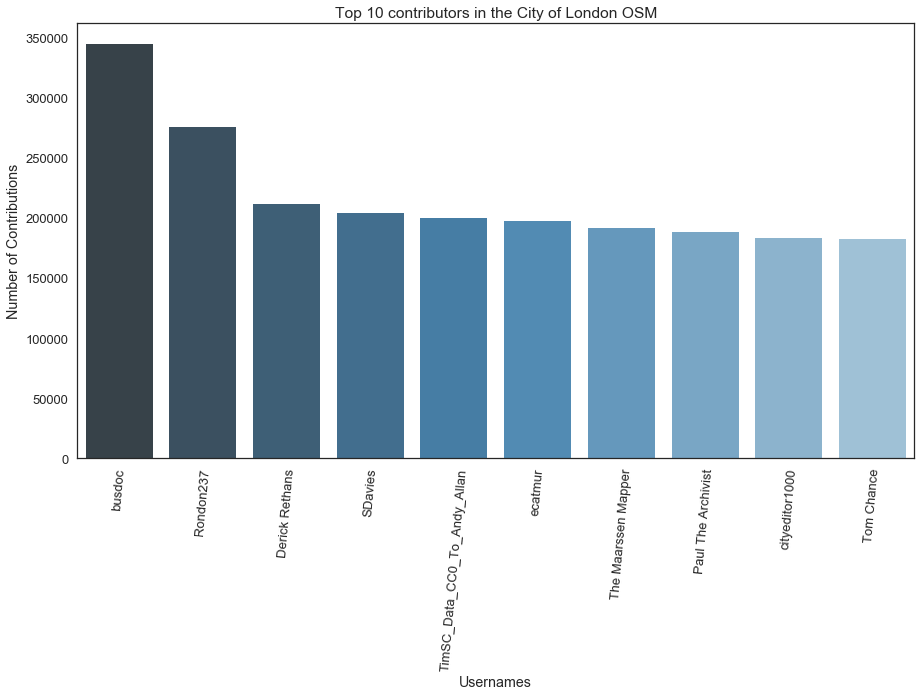

In [73]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

top10_contributors = pd.DataFrame.from_records(res, columns=["Usernames", "Number of Contributions"])

sns.set(style="white", context="talk")
plt.figure(figsize=(15,8))
g = sns.barplot('Usernames','Number of Contributions', data = top10_contributors, palette = ("Blues_d"))
plt.title('Top 10 contributors in the City of London OSM')
plt.ylabel('Number of Contributions')
plt.xlabel('Usernames')
loc, labels = plt.xticks()
g.set_xticklabels(labels, rotation=85)
plt.show()

## Number of nodes and ways
The following quiries return the number of nodes and ways stored in the database.

In [40]:
import sqlite3
import pprint

sqlite_file = "project.db"
conn = sqlite3.connect(sqlite_file)
cur = conn.cursor()

cur.execute("SELECT COUNT(id) FROM nodes;")
pprint.pprint("Number of nodes in the Nodes table: " + str(cur.fetchall()[0][0]))


conn.close()

'Number of nodes in the Nodes table: 7254473'


In [41]:
import sqlite3
import pprint

sqlite_file = "project.db"
conn = sqlite3.connect(sqlite_file)
cur = conn.cursor()

cur.execute(" SELECT COUNT(id) FROM ways;")
pprint.pprint("Number of ways in the Ways table: " + str(cur.fetchall()[0][0]))


conn.close()

'Number of ways in the Ways table: 1181849'


## Count Tourism Related Categories Descending
A query to get the top 10 amenities recorded in the OSM shows that hotels, information, artwork, attraction, museum, viewpoint, picnic_site, 'hostel', guest_house', and gallery are the most frequent amenities in the London's OSM map data.

In [36]:
import sqlite3
import pprint

sqlite_file = "project.db"
conn = sqlite3.connect(sqlite_file)
cur = conn.cursor()

cur.execute ("SELECT tags.value, COUNT(*) as count FROM (SELECT * FROM nodes_tags UNION ALL \
             SELECT * FROM ways_tags) tags \
             WHERE tags.key LIKE '%tourism'\
             GROUP BY tags.value \
             ORDER BY count DESC LIMIT 10;")

res = cur.fetchall()
pprint.pprint(res)

con.close()

[('hotel', 1349),
 ('information', 1042),
 ('artwork', 729),
 ('attraction', 492),
 ('museum', 248),
 ('viewpoint', 155),
 ('picnic_site', 119),
 ('hostel', 94),
 ('guest_house', 92),
 ('gallery', 91)]


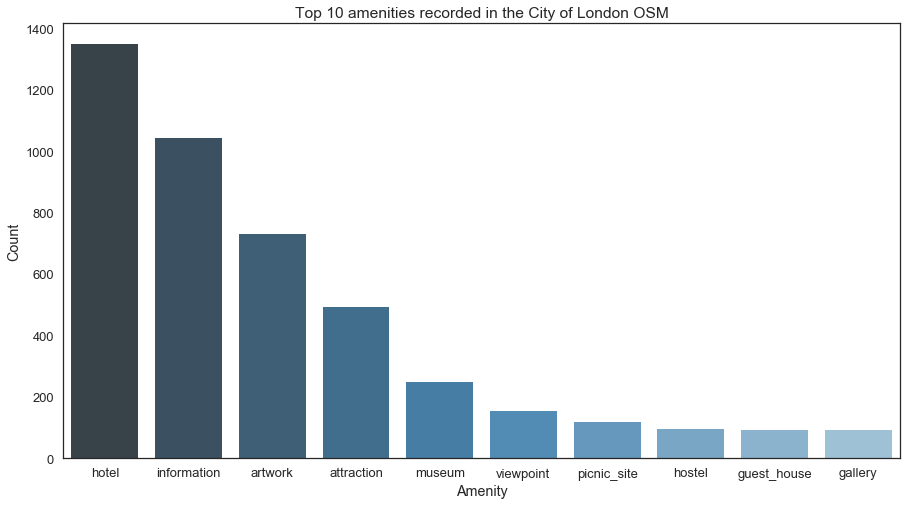

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

amenity_top10 = pd.DataFrame.from_records(res, columns=["Categories", "Count"])
#df.plot(kind="bar", x =df.Categories, figsize = [12, 8], title = 'Top 10 amenities recorded in the City of London OSM', fontsize= 10)

sns.set(style="white", context="talk")
plt.figure(figsize=(15,8))
sns.barplot('Categories','Count', data = amenity_top10, palette = ("Blues_d"))
plt.title('Top 10 amenities recorded in the City of London OSM')
plt.ylabel('Count')
plt.xlabel('Amenity')
plt.show()

## Top 5 Most Popular Fast Food Chain
It is time ti query the database and find our whats the top 5 fast food chains.

In [82]:
import pprint

sqlite_file = "project.db"
conn = sqlite3.connect(sqlite_file)
cur = conn.cursor()

cur.execute ("SELECT nodes_tags.value, COUNT(*) as num FROM nodes_tags JOIN (SELECT DISTINCT(id) \
             FROM nodes_tags WHERE value='fast_food') i ON nodes_tags.id=i.id WHERE nodes_tags.key='name' \
             GROUP BY nodes_tags.value ORDER BY num DESC LIMIT 5;")

res = cur.fetchall()
pprint.pprint(res)


conn.close()

[('Subway', 134),
 ("McDonald's", 99),
 ('KFC', 74),
 ('Burger King', 45),
 ("Domino's Pizza", 32)]


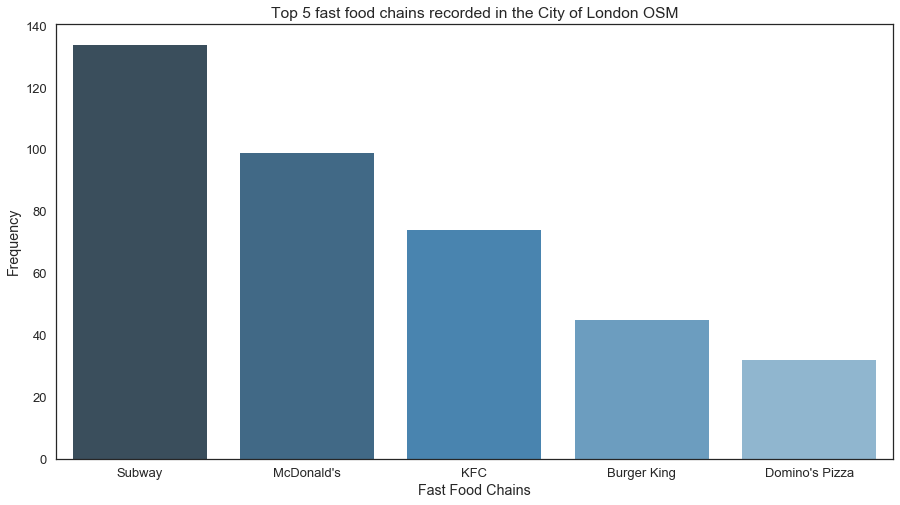

In [84]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

fast_food_chains_top10 = pd.DataFrame.from_records(res, columns=["Fast Food Chains", "Frequency"])
#df.plot(kind="bar", x =df.Categories, figsize = [12, 8], title = 'Top 10 amenities recorded in the City of London OSM', fontsize= 10)

sns.set(style="white", context="talk")
plt.figure(figsize=(15,8))
sns.barplot('Fast Food Chains','Frequency', data = fast_food_chains_top10, palette = ("Blues_d"))
plt.title('Top 5 fast food chains recorded in the City of London OSM')
plt.ylabel('Frequency')
plt.xlabel('Fast Food Chains')
plt.show()

## Top 10 most popular cuisine
Lets find out 

In [86]:
import pprint

sqlite_file = "project.db"
conn = sqlite3.connect(sqlite_file)
cur = conn.cursor()

cur.execute ('''
SELECT nodes_tags.value, COUNT(*) as num
FROM nodes_tags JOIN (SELECT DISTINCT(id) FROM nodes_tags WHERE value='restaurant') i ON nodes_tags.id=i.id
WHERE nodes_tags.key='cuisine'
GROUP BY nodes_tags.value
ORDER BY num DESC LIMIT 10;
''')

res = cur.fetchall()
pprint.pprint(res)


conn.close()

[('indian', 444),
 ('italian', 375),
 ('chinese', 200),
 ('pizza', 133),
 ('japanese', 106),
 ('thai', 99),
 ('french', 80),
 ('turkish', 71),
 ('burger', 64),
 ('mexican', 50)]


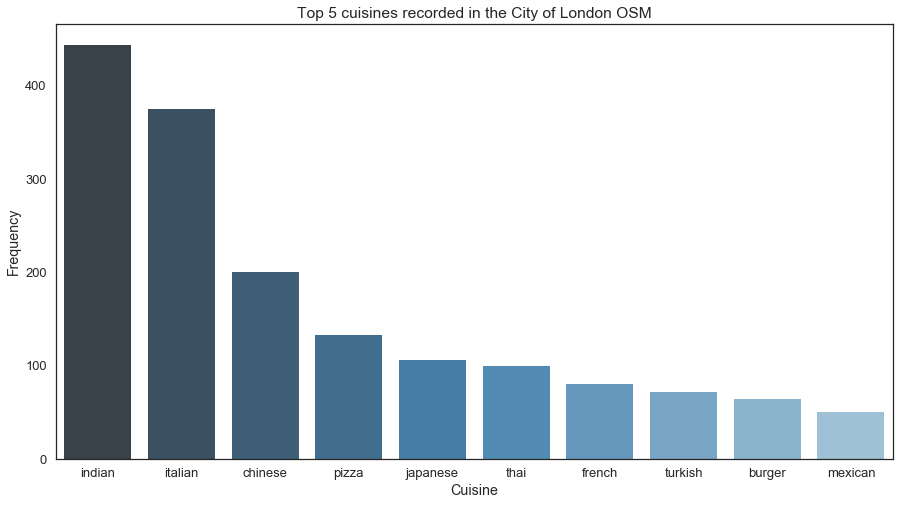

In [89]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

cuisine_top10 = pd.DataFrame.from_records(res, columns=["Cuisine", "Frequency"])
#df.plot(kind="bar", x =df.Categories, figsize = [12, 8], title = 'Top 10 amenities recorded in the City of London OSM', fontsize= 10)

sns.set(style="white", context="talk")
plt.figure(figsize=(15,8))
sns.barplot('Cuisine','Frequency', data = cuisine_top10, palette = ("Blues_d"))
plt.title('Top 5 cuisines recorded in the City of London OSM')
plt.ylabel('Frequency')
plt.xlabel('Cuisine')
plt.show()

# <div id="Ideas">7) Additional Ideas</div>

In this section some ideas about how to improve the London Open Street Map dataset are
discussed.

- Some Issues found in the dataset during the data wrangling process that can be improved.
Postal codes, This data can be improved as some postal codes were not followed the official postal code pattern provided by the UK goverment. A way to improve the postal codes to do this is to cross validate against the Royal Mail
(http://www.royalmail.com/find-a-postcode) database, to prevent that users enter wrong
information. Another is to cross validate the postal code fields with latitude and longitude
points to ensure that postal codes of South London do not end up in North London.
- Streets. In the street name field there were some observations containing more than one
street address which should be fixed to prevent consistency issues. This can be improved
by implementing field validation and regular expressions to stop the user from entering
streets with problematic characters.
- Coordinates, auditing the coordinates has shown that more than 700000 entries were given with invalid coordinates. This means that users have given false information and wrong coordinates. This can also be improved by adding regular expressions and hidden fuctionalities which will check the users' input and prevent the invalid information.
- Gamification. A gamification approach can provide tools that encourage others users
to validate data and create a community that seeks to improve data quality. Consumers of
Open Street Maps lack mechanisms to assess the data quality. For instance, many new
users make mistakes during their learning curve to add information to the map, some bots
modify the data programmatically raising issues of validity and other users just input
misleading data. In this sense, the dataset does not contain information to assess the
reliability of the data. A way out of this problem is to use a system of performance metrics, badges and trophies
to create a ladder that encourages users to ensure data quality. For instance, a user that is
continuously adding data is rewarded with points and if other users validate that his data is
correct he earns badges that recognize him as trustworthy. Moreover, the opposite can be
true as well and the user can lose points based on incorrect or misleading information.
Such information can be included in the dataset allowing to measure how reliable are the
objects in the map

# <div id="Conclusion">8) Conclusion of this case study
In this case study Python and SQLite were used to wrangle the City of London Open Street Map. As
this dataset contains lots of information the data types, node coordinates, postal code format, street
names were chosen to assess the quality of the dataset.
As a result of the auditing process it can be inferred that the dataset is not cleaned enough, for example
the format of the street names and the format of the postal codes were not totally correct.
Another, exercise was to audit the coordinates which all are in the correct format. Bearing these in mind, it can be concluded that the OSM for the City of London is valuable information, with an appropriate degree of data quality. However, data wrangling plays a key role to
assess how accurate, valid, complete, consistent and uniform it is, for the purpose for which the data wants to be used.

# <div id="Sources">9) Sources</div>
- https://en.wikipedia.org/wiki/Postcodes_in_the_United_Kingdom
- Stackoverflow.com
- https://www.sqlite.org